In [ ]:
###~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Code for some unsupervised algorithms
# Right now for individual event 1 files
# Runs k-means clustering and 
# Dayla's cool RF unsupervised algorithm, which is trained to decipher
# between frankenstein data [reproduces distribution of parameters
# but without correlations] and real data and then identifies outliers.
###~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

In [11]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn import preprocessing
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import numpy.ma as ma


def plot_from_df(df, name, var1, var2):
    df = df.dropna()
 
    x = df[var1]#[0:n_points]#[np.array(binary_preds)==1]#model_lda.predict(xs)
    y = df[var2]#[0:n_points]#[np.array(binary_preds)==1]

    
    
    nbins=100#int(len(x)/10)
    
    img_data, yedges, xedges = np.histogram2d(y, x, nbins)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

    #print('# Real events: ', len(input_data.loc[good_hyperbola]), '# All events: ',len(input_data))
    #print('# bg events: ', len(input_data)-len(input_data.loc[good_hyperbola]))
    try:
        plt.clf()
        plt.imshow(ma.masked_where(img_data==0, img_data),  
                        rasterized=True, cmap='viridis', origin='data', extent=extent, 
                       norm=matplotlib.colors.LogNorm())
        plt.xlabel(var1)
        plt.ylabel(var2)
    
        plt.colorbar()
        plt.title(name)
        plt.show()
    except:
        try:
            plt.clf()
            plt.imshow(ma.masked_where(img_data==0, img_data),  
                            rasterized=True, cmap='viridis', origin='data', extent=extent)
            plt.xlabel(var1)
            plt.ylabel(var2)
            plt.colorbar()
            plt.title(name)
            plt.show()
        except:
            plt.clf()
            plt.imshow(ma.masked_where(img_data==0, img_data),  
                            rasterized=True, cmap='viridis',  extent=extent)
            plt.xlabel(var1)
            plt.ylabel(var2)
            plt.colorbar()
            plt.title(name)
            plt.show()
    
    '''plt.clf()
    plt.scatter(x, y, c = df['pha'], cmap='viridis')
    plt.colorbar()
    plt.title(name)
    plt.show()'''

         Unnamed: 0          time  crsv  crsu  amp_sf  av1   av2  av3  au1  \
0                 0  6.196317e+07    31    33       1  102   501   46   42   
1                 1  6.196317e+07    22    27       1   50   433   81   42   
2                 2  6.196318e+07    47    13       1  204   612   57  288   
3                 3  6.196318e+07    40    33       1  193   852   75  422   
4                 4  6.196318e+07     2    21       1  394   542   22   55   
...             ...           ...   ...   ...     ...  ...   ...  ...  ...   
6951805     6951805  6.201342e+07    29    31       1  314  1147   70  192   
6951806     6951806  6.201342e+07    16    57       1  192   409   28   90   
6951807     6951807  6.201342e+07    28    30       1  264  1744  148  492   
6951808     6951808  6.201342e+07    57    56       1  325   487  217   89   
6951809     6951809  6.201342e+07    32    20       1  290   416   29  265   

          au2  ...  PI exceeding 255  Event time tag is out of 

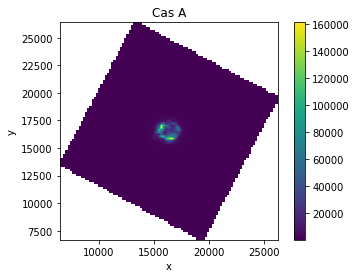

In [12]:
# Import .csv files from event file
datadir = '../data/csv_files/'
id = 1505

# These 'science_dataframe' files are event 1 files with the gti mask applied (but no additional filtering)
data = pd.io.parsers.read_csv(datadir+'science_dataframe_'+str(id)+'.csv', sep=',')#, header=[0])
print(data)
plot_from_df(data, 'Cas A', 'x', 'y')

In [13]:
print(data.columns)

Index(['Unnamed: 0', 'time', 'crsv', 'crsu', 'amp_sf', 'av1', 'av2', 'av3',
       'au1', 'au2', 'au3', 'rawx', 'rawy', 'chipx', 'chipy', 'tdetx', 'tdety',
       'detx', 'dety', 'x', 'y', 'pha', 'pi', 'sumamps', 'chip_id', 'fp_u',
       'fb_u', 'fp_v', 'fb_v', 'AV3 corrected for ringing',
       'AU3 corrected for ringing', 'Event impacted by prior event (piled up)',
       'Shifted event time', 'Event telemetered in NIL mode',
       'V axis not triggered', 'U axis not triggered',
       'V axis center blank event', 'U axis center blank event',
       'V axis width exceeded', 'U axis width exceeded', 'Shield PMT active',
       'Upper level discriminator not exceeded',
       'Lower level discriminator not exceeded', 'Event in bad region',
       'Amp total on V or U = 0', 'Incorrect V center', 'Incorrect U center',
       'PHA ratio test failed', 'Sum of 6 taps = 0', 'Grid ratio test failed',
       'ADC sum on V or U = 0', 'PI exceeding 255',
       'Event time tag is out of seque

In [14]:
# Prepare the fp and fb variables:
a_u = data["au1"]  # otherwise known as "a1"
b_u = data["au2"]  # "a2"
c_u = data["au3"]  # "a3"

a_v = data["av1"]
b_v = data["av2"]
c_v = data["av3"]

with np.errstate(invalid='ignore'):
    # Do the U axis
    fp_u = ((c_u - a_u) / (a_u + b_u + c_u))
    fb_u = b_u / (a_u + b_u + c_u)

    # Do the V axis
    fp_v = ((c_v - a_v) / (a_v + b_v + c_v))
    fb_v = b_v / (a_v + b_v + c_v)

data['fp_u'] = fp_u
data['fb_u'] = fb_u
data['fp_v'] = fp_v
data['fb_v'] = fb_v

In [15]:
# Select which predictors you want to include in the clustering:
print('options for features', data.columns[:])

all_feature_list = ['Unnamed: 0', 'time', 'crsv', 'crsu', 'amp_sf', 'av1', 'av2', 'av3',
       'au1', 'au2', 'au3', 'rawx', 'rawy', 'chipx', 'chipy', 'tdetx', 'tdety',
       'detx', 'dety', 'x', 'y', 'pha', 'pi', 'sumamps', 'chip_id', 'fp_u',
       'fb_u', 'fp_v', 'fb_v', 'AV3 corrected for ringing',
       'AU3 corrected for ringing', 'Event impacted by prior event (piled up)',
       'Shifted event time', 'Event telemetered in NIL mode',
       'V axis not triggered', 'U axis not triggered',
       'V axis center blank event', 'U axis center blank event',
       'V axis width exceeded', 'U axis width exceeded', 'Shield PMT active',
       'Upper level discriminator not exceeded',
       'Lower level discriminator not exceeded', 'Event in bad region',
       'Amp total on V or U = 0', 'Incorrect V center', 'Incorrect U center',
       'PHA ratio test failed', 'Sum of 6 taps = 0', 'Grid ratio test failed',
       'ADC sum on V or U = 0', 'PI exceeding 255',
       'Event time tag is out of sequence', 'V amp flatness test failed',
       'U amp flatness test failed', 'V amp saturation test failed',
       'U amp saturation test failed', 'V hyperbolic test failed',
       'U hyperbolic test failed', 'Hyperbola test passed',
       'Hyperbola test failed']

feature_list = ['time', 'crsv', 'crsu', 'amp_sf', 'av1', 'av2', 'av3',
       'au1', 'au2', 'au3', 'rawx', 'rawy', 'chipx', 'chipy', 'tdetx', 'tdety',
       'detx', 'dety', 'x', 'y', 'pha', 'pi', 'sumamps', 'chip_id', 'fp_u',
       'fb_u', 'fp_v', 'fb_v']

#feature_list = [ 'amp_sf', 'av1', 'av2', 'av3',
#       'au1', 'au2', 'au3', 'pha', 'pi', 'sumamps']


data_select = data[feature_list]

# Also delete nans
data_select = data_select.dropna()

options for features Index(['Unnamed: 0', 'time', 'crsv', 'crsu', 'amp_sf', 'av1', 'av2', 'av3',
       'au1', 'au2', 'au3', 'rawx', 'rawy', 'chipx', 'chipy', 'tdetx', 'tdety',
       'detx', 'dety', 'x', 'y', 'pha', 'pi', 'sumamps', 'chip_id', 'fp_u',
       'fb_u', 'fp_v', 'fb_v', 'AV3 corrected for ringing',
       'AU3 corrected for ringing', 'Event impacted by prior event (piled up)',
       'Shifted event time', 'Event telemetered in NIL mode',
       'V axis not triggered', 'U axis not triggered',
       'V axis center blank event', 'U axis center blank event',
       'V axis width exceeded', 'U axis width exceeded', 'Shield PMT active',
       'Upper level discriminator not exceeded',
       'Lower level discriminator not exceeded', 'Event in bad region',
       'Amp total on V or U = 0', 'Incorrect V center', 'Incorrect U center',
       'PHA ratio test failed', 'Sum of 6 taps = 0', 'Grid ratio test failed',
       'ADC sum on V or U = 0', 'PI exceeding 255',
       'Event tim

In [16]:
# Standardize the data prior to k-means:
standardized_data = preprocessing.scale(data_select)
print(standardized_data)

/Users/rebeccanevin/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:194: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


[[-1.72278264  0.13309845  0.34900499 ...  0.78357093 -0.30218111
   1.05323334]
 [-1.72277914 -0.81387873 -0.28732523 ... -0.12141821  0.20021935
   1.01233354]
 [-1.72272964  1.81661342 -1.77209573 ...  0.08094688 -0.59418737
   0.36686099]
 ...
 [ 1.75658059 -0.18256061  0.03083988 ...  0.73561165 -0.18664503
   1.41079574]
 [ 1.75658125  2.86881028  2.78827081 ... -1.80981535 -0.36858519
  -1.83720398]
 [ 1.7566348   0.23831813 -1.02971048 ... -2.11871492 -1.25830089
  -0.94000711]]


In [17]:

print(np.shape(standardized_data))

(6900503, 28)


In [18]:
### Okay, why not run q quick clustering ?

nclusters=6
kmeans = KMeans(n_clusters=nclusters, random_state=0)
clusters = kmeans.fit_predict(standardized_data)
centers = kmeans.cluster_centers_#.reshape(nclusters, resampling_shape, resampling_shape)
print('centers', centers)
# These are meant to be repopulated every time you cut the galaxies
#bad_galaxies = np.zeros(np.shape(MB_matrix_rescaled))
#bad_galaxies_ifus = []



KeyboardInterrupt: 

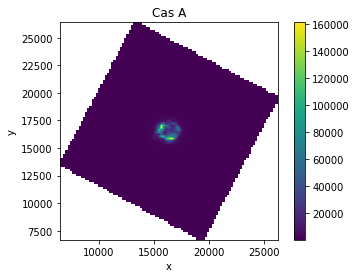

extent [[6684.405, 26623.547000000002], [6481.045999999999, 26216.475]]
Cluster #  0  length is  439024  fractional length is  0.06
Cluster #  1  length is  428603  fractional length is  0.06
Cluster #  2  length is  1403642  fractional length is  0.2
Cluster #  3  length is  410192  fractional length is  0.06
Cluster #  4  length is  460976  fractional length is  0.07
Cluster #  5  length is  3758066  fractional length is  0.54


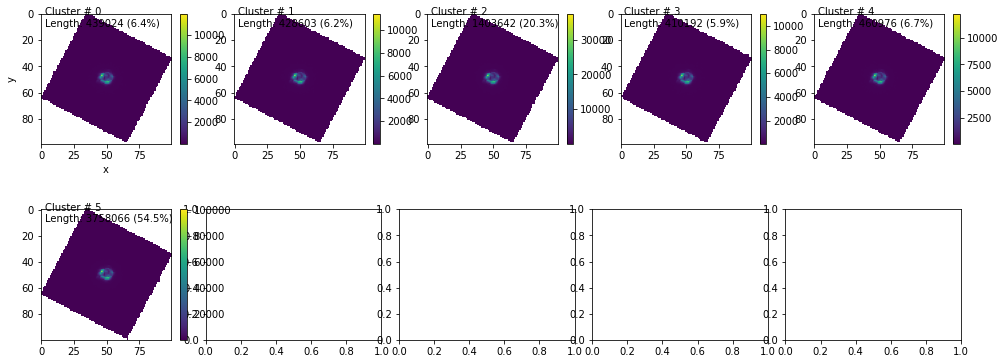

In [20]:
# Plot where the centers fall:
plt.clf()

plot_x = 'x'
plot_y = 'y'

index_x = all_feature_list.index(plot_x)
index_y = all_feature_list.index(plot_y)

plot_from_df(data, 'Cas A', plot_x, plot_y)



'''
standardized_data_df = pd.DataFrame(standardized_data, columns=feature_list)

plot_from_df(standardized_data_df, 'Cas A', plot_x, plot_y)

for i in range(nclusters):
    plt.scatter(centers[i][index_x], centers[i][index_y])
plt.xlabel('normalized '+plot_x)
plt.ylabel('normalized '+plot_y)
plt.show()
'''



# Classify all of the points into their proper cluster:


data_np = np.array(data)
extent = [[np.min(data_np[:,index_y]), np.max(data_np[:,index_y])], [np.min(data_np[:,index_x]), np.max(data_np[:,index_x])]]
print('extent', extent)
      


cluster={}
cluster_e={}

fig, axs = plt.subplots(2,5, figsize=(17, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.1)

axs = axs.ravel()

#cluster_name=[]
for n in range(nclusters):

    cluster[n]=[]
    
    for j in range(np.shape(standardized_data)[0]):
        if clusters[j]==n:
            cluster[n].append(data_np[j])
            #cluster_e[n].append(np.reshape(data_ml_rot_e[j,:],(resampling_shape,resampling_shape)))
            
    print('Cluster # ', n, ' length is ', len(cluster[n]), 
          ' fractional length is ', round(len(cluster[n])/np.shape(standardized_data)[0],2))
    nbins=100#int(len(x)/10)
    
    cluster_stack = np.vstack(cluster[n])
    
    xs = cluster_stack[:,index_x]
    ys = cluster_stack[:,index_y]
    
    img_data, yedges, xedges = np.histogram2d(ys, xs, nbins, range=extent)
            #xedges[0], xedges[-1], yedges[0], yedges[-1]]

    #print('# Real events: ', len(input_data.loc[good_hyperbola]), '# All events: ',len(input_data))
    #print('# bg events: ', len(input_data)-len(input_data.loc[good_hyperbola]))
    #try:
    
    
    axs[n].annotate('Cluster # '+str(n)+'\nLength: '+str(len(cluster[n]))+' ('+str(round(100*len(cluster[n])/np.shape(standardized_data)[0],1))+'%)', 
                   xy = (0.03, 0.9), xycoords='axes fraction')
    
    im = axs[n].imshow(ma.masked_where(img_data==0, img_data),  
                    rasterized=True, cmap='viridis')#, 
                  # norm=matplotlib.colors.LogNorm())#, extent=extent
    if n==0:
        axs[n].set_xlabel(plot_x)
        axs[n].set_ylabel(plot_y)

    plt.colorbar(im, ax = axs[n], fraction=0.046)

plt.show()


In [ ]:
# Do the same thing with fp_u and fb_u
plt.clf()

plot_x = 'fp_u'
plot_y = 'fb_u'

index_x = all_feature_list.index(plot_x)
index_y = all_feature_list.index(plot_y)


plot_from_df(data, 'Cas A', plot_x, plot_y)

'''
for i in range(nclusters):
    plt.scatter(centers[i][index_x], centers[i][index_y])
plt.xlabel('normalized '+plot_x)
plt.ylabel('normalized '+plot_y)
plt.show()

'''


extent = [[np.min(data_np[:,index_y]), np.max(data_np[:,index_y])], [np.min(data_np[:,index_x]), np.max(data_np[:,index_x])]]
print('extent', extent)
fig, axs = plt.subplots(2,5, figsize=(17, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.1)

axs = axs.ravel()

#cluster_name=[]
for n in range(nclusters):
    
    cluster_stack = np.vstack(cluster[n])

    
    xs = cluster_stack[:,index_x]
    ys = cluster_stack[:,index_y]
    
    img_data, yedges, xedges = np.histogram2d(ys, xs, nbins, range=extent)
            #xedges[0], xedges[-1], yedges[0], yedges[-1]]

    #print('# Real events: ', len(input_data.loc[good_hyperbola]), '# All events: ',len(input_data))
    #print('# bg events: ', len(input_data)-len(input_data.loc[good_hyperbola]))
    #try:
    
    
    axs[n].annotate('Cluster # '+str(n)+'\nLength: '+str(len(cluster[n]))+' ('+str(round(100*len(cluster[n])/np.shape(standardized_data)[0],1))+'%)', 
                   xy = (0.03, 0.9), xycoords='axes fraction')
    
    im = axs[n].imshow(ma.masked_where(img_data==0, img_data),  
                    rasterized=True, cmap='viridis')#, origin='data')#, 
                  # norm=matplotlib.colors.LogNorm())#, extent=extent
    if n==0:
        axs[n].set_xlabel(plot_x)
        axs[n].set_ylabel(plot_y)

    plt.colorbar(im, ax = axs[n], fraction=0.046)

plt.show()


# Do the same thing with fp_u and fb_u
plt.clf()

plot_x = 'pha'
plot_y = 'sumamps'

index_x = all_feature_list.index(plot_x)
index_y = all_feature_list.index(plot_y)

plot_from_df(data, 'Cas A', plot_x, plot_y)
'''
for i in range(nclusters):
    plt.scatter(centers[i][index_x], centers[i][index_y])
plt.xlabel('normalized '+plot_x)
plt.ylabel('normalized '+plot_y)
plt.show()
'''



extent = [[np.min(data_np[:,index_y]), np.max(data_np[:,index_y])], [np.min(data_np[:,index_x]), np.max(data_np[:,index_x])]]

fig, axs = plt.subplots(2,5, figsize=(17, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.1)

axs = axs.ravel()

#cluster_name=[]
for n in range(nclusters):
    
    cluster_stack = np.vstack(cluster[n])

    
    xs = cluster_stack[:,index_x]
    ys = cluster_stack[:,index_y]
    
    img_data, yedges, xedges = np.histogram2d(ys, xs, nbins, range=extent)
            #xedges[0], xedges[-1], yedges[0], yedges[-1]]

    #print('# Real events: ', len(input_data.loc[good_hyperbola]), '# All events: ',len(input_data))
    #print('# bg events: ', len(input_data)-len(input_data.loc[good_hyperbola]))
    #try:
    
    
    axs[n].annotate('Cluster # '+str(n)+'\nLength: '+str(len(cluster[n]))+' ('+str(round(100*len(cluster[n])/np.shape(standardized_data)[0],1))+'%)', 
                   xy = (0.03, 1), xycoords='axes fraction')
    
    im = axs[n].imshow(ma.masked_where(img_data==0, img_data),  
                    rasterized=True, cmap='viridis')#, origin='data')#, 
                  # norm=matplotlib.colors.LogNorm())#, extent=extent
    if n==0:
        axs[n].set_xlabel(plot_x)
        axs[n].set_ylabel(plot_y)

    plt.colorbar(im, ax = axs[n], fraction=0.046)

plt.show()


(6900503, 28)
x = fb_u
y = fp_v


<Figure size 432x288 with 0 Axes>

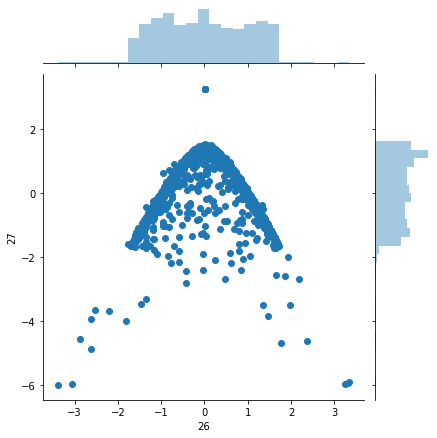

In [39]:
### Now do the RF clustering where you make frankenstein data
print(np.shape(standardized_data))
import seaborn as sns
from random import randint



plt.clf()

pix_1 = 26# This is just randomly selecting a feature in the event table
pix_2 = 27

print('x = '+feature_list[pix_1])
print('y = '+feature_list[pix_2])

x = standardized_data[0:2000,pix_1]
y = standardized_data[0:2000,pix_2]
g = (sns.jointplot(x, y)
        .set_axis_labels(str(pix_1), str(pix_2)));#, kind="hex"

In [41]:
## Make a marginal distribution

value = randint(0, np.shape(standardized_data)[0])
print(value)

frankenstein_array = np.zeros(np.shape(standardized_data))

for i in range(np.shape(standardized_data)[0]):
    frankenstein_gal = []
    for j in range(np.shape(standardized_data)[1]):
        ran_int = randint(0,np.shape(standardized_data)[0] - 1)
        frankenstein_gal.append(standardized_data[ran_int,j])
    frankenstein_array[i,:] = frankenstein_gal
    
print(np.shape(frankenstein_array))
print(np.shape(standardized_data))
plot_from_df(frankenstein_array, 'Franken Cas A', 'x', 'y')

STOP
# plot a random collection of galaxies once they have been rebinned and resized
plt.clf()
sns.set_style("dark")
fig = plt.figure(figsize = (25,15))
fig.subplots_adjust(hspace=0.3, 
                    wspace=0.15)

for j in range(6):
    ax = fig.add_subplot(1,6, j+1)
    
    ran_int = randint(0,np.shape(frankenstein_array)[0] - 1)
    
    # Plot three random versions of Cas A (uncorrelated)
    plot_from_df(frankenstein_arr, 'Franken Cas A', 'x', 'y')

    im = ax.imshow(np.reshape(frankenstein_array[ran_int], (np.shape(MB_matrix_flat)[1],np.shape(MB_matrix_flat)[1])), cmap='RdBu_r', norm=MidpointNormalize(midpoint=0))
plt.show()

982716
(6900503, 28)


AttributeError: 'numpy.ndarray' object has no attribute 'dropna'

(6900503, 28)
(6900503, 28)


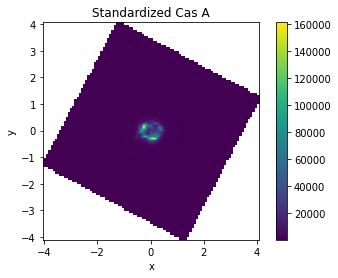

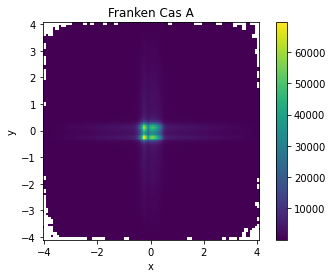

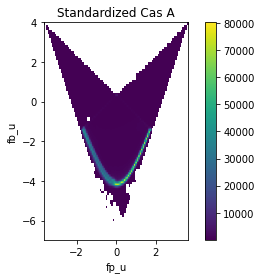

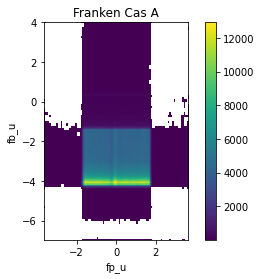

In [47]:
# Explore what the franken event file looks like 
print(np.shape(frankenstein_array))
print(np.shape(standardized_data))
plot_from_df(pd.DataFrame(standardized_data, columns = feature_list), 'Standardized Cas A', 'x', 'y')

plot_from_df(pd.DataFrame(frankenstein_array, columns = feature_list), 'Franken Cas A', 'x', 'y')


plot_from_df(pd.DataFrame(standardized_data, columns = feature_list), 'Standardized Cas A', 'fp_u', 'fb_u')

plot_from_df(pd.DataFrame(frankenstein_array, columns = feature_list), 'Franken Cas A', 'fp_u', 'fb_u')


In [52]:


from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

def testAndTrainIndices(test_fold, Nfolds, folds):

    print('finding test and train indices...')

    train_folds = np.delete(np.arange(Nfolds), test_fold)

    test_ind   = [i for i in range(len(folds)) if folds[i]==test_fold]
    train_ind  = [i for i in range(len(folds)) if folds[i] in train_folds]

    return test_ind, train_ind

def run_RFC(df_merg, features_list,  verbose):
    # These are adjustable RFR parameters
    Nfolds = 10
    Ndat = 5000

    features = df_merg[features_list].values
    #,'nspax','re'
    Nfeatures = len(features[0])
    
    #dat['features']#.reshape(-1,1)
    labels = df_merg[['class']].values
    folds = np.arange(len(labels))%Nfolds
    
    
    #Test on fold 0, train on the remaining folds:
    test_ind, train_ind = testAndTrainIndices(test_fold = 0, Nfolds = Nfolds, folds=folds)
    
    #divide features and labels into test and train sets:
    test_features = features[test_ind]
    test_labels   = labels[test_ind]
   
    train_features  = features[train_ind]
    train_labels    = labels[train_ind]

    print('training fold 0')
    #make a random forest model:
    model = RandomForestClassifier(max_depth=10, random_state=42)
    model.fit(train_features, train_labels)

    print('predicting...')
    # Predict on new data
    preds = model.predict(test_features)
    #print out the first few mass predictions to see if they make sense:
    if verbose=='yes':
        for h in range(10):
            print(test_labels[h], preds[h])


    # rank feature importance:
    importances = model.feature_importances_
    std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
    indices = np.argsort(importances)[::-1]

    if verbose=='yes':
        # Plot the feature importances of the forest
        plt.clf()
        plt.figure(figsize=(15,5))
        #plt.title("RFR Feature importances for "+str(run))
        plt.bar(range(Nfeatures), importances[indices], yerr=std[indices], align="center", color='pink')
        plt.xticks(range(Nfeatures), indices)
        plt.xlim([-1, Nfeatures])
        plt.show()
        
        #plt.savefig('feature_importance_'+str(run)+'_rando.pdf')
        
        
        
        print('Importance in Order ~~~~')
    
    # find the index of the random one:
    random_idx = features_list.index('random')
    random_value = importances[random_idx]
    random_std = std[random_idx]
    if verbose=='yes':
        print('random idx', random_idx)
        print('random_value', random_value)
    unin_here = []
    important_here = []
    for j in range(len(indices)):
        #if importances[indices[j]] - std[indices[j]] > 0:
        print(indices[j], features_list[indices[j]])
        if importances[indices[j]] > random_value:# or importances[indices[j]] - std[indices[j]] > random_value - random_std:
            important_here.append(features_list[indices[j]])
        else:
            unin_here.append(features_list[indices[j]])
        
  
    return important_here, unin_here, model



In [ ]:
# Now train a random forest to distinguish between real and franken data:
# label one as ones and one as zeros
df_0 = pd.DataFrame(standardized_data, columns=feature_list)
df_1 = pd.DataFrame(frankenstein_array, columns=feature_list)

df_0['class'] = 'real'
df_1['class'] = 'synthetic'
most_imp, value = run_RFC(pd.concat([df_0,df_1]), 
                          feature_list, verbose=True)



finding test and train indices...
training fold 0


/Users/rebeccanevin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [ ]:
#Wait so you need to figure out which spaxel this is
#322, where is this?

full_length = np.shape(MB_matrix_rescaled)[1]
empty = np.zeros(np.shape(MB_matrix_rescaled)[1])
for j in range(len(most_imp)):
    empty[most_imp[j]] = value[j]
    
print(empty)

# how does this show value?

'''
#side = int(np.sqrt(len(empty)))
twod = np.reshape(empty, (side,side))
plt.imshow(twod)
plt.colorbar()
plt.show()
'''